# CIS545 Project: Sentiment Analysis Using Twitter With Weather Effects

*  **Team members**: 

    Haoxiang Ruan, R. Alan Cooper, Yin Yin

*   **Plan description**: 
    
    We did a sentiment analysis on Twitter posts based on weather conditions in a person’s area at the time of posting. Our ultimate goal is to predict weather condition in a specific area based on emotions shown in their tweets during a specified day.
   
    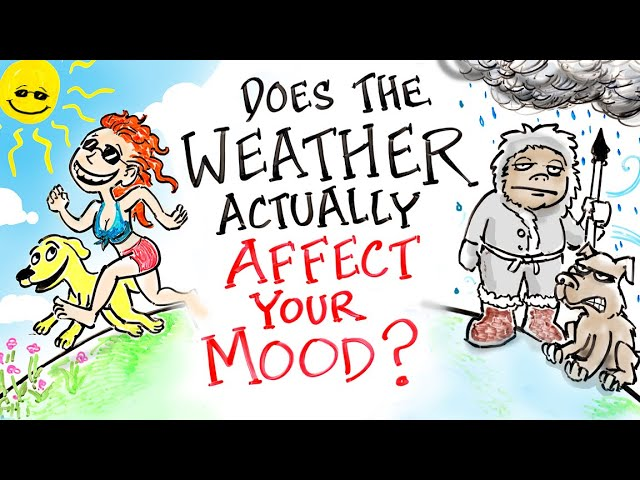










#   0 . Installations and Packages

### **0.1 Mount at Shared Drive**






In [2]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT, force_remount=True)

Mounted at /content/gdrive


In [3]:
# If it works, it will have gdrive in the result
!ls

gdrive	sample_data


In [4]:
# Change the current directory to our data folder.
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


### **0.2 Install Packages and Setup**

In [6]:
!pip install wwo-hist
!pip install nrclex
!python -m textblob.download_corpora

     |████████████████████████████████| 399kB 7.0MB/s 
  Created wheel for nrclex: filename=NRCLex-3.0.0-cp36-none-any.whl size=43311 sha256=20501372cfa3ee638f1b028098d8109037fb16cda29f7690fc3a051f118b4ebc
  Stored in directory: /root/.cache/pip/wheels/17/31/64/035a8d245b4c217aeb8e8a2702d05dc91544b9c2334db72414
Successfully built nrclex
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk

In [7]:
# Standard Python Libraries
import json
import csv
import requests
import re

# Data Processing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tweet/Weather/Sentiment Data Collection Libraries
import tweepy as tw
from wwo_hist import retrieve_hist_data
from nrclex import NRCLex

# Machine Learning Libraries (via scikit-learn)
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

#  1. Data Preparation

In this section, we prepared all the data we need in this project.

We first extracted the tweets, test gathering sentiment data on a dummy dataset, and weather information from weatherAPI.



## 1.1 Twitter Data

In this section, we extract 72,000 tweets equally spread across from 2020-12-02 to 2020-12-10 in eight cities around the United States:

*   Boston
*   Chicago
*   Houston
*   Los Angeles
*   New York
*   Philadelphia
*   Seattle
*   Phoenix






In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/Tweets/

/content/gdrive/Shareddrives/CIS545_project/Data/Tweets


### **1.1.1 Keys and Credentials**

In order to extract tweets from Twitter, we set up a Twitter accounts and applied for Developer Access. Upon granting access, Twitter generates four keys to use as API credentials to access Twitter data from Python.

Source: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/


In [ ]:
# Alan - Twitter Developer Keys:
with open("/content/gdrive/Shareddrives/CIS545_project/twitter_keys-Alan.txt", 'r') as f:
    keys = f.read().split('\n')
    consumer_key        = keys[0]
    consumer_secret     = keys[1]
    access_token        = keys[2]
    access_token_secret = keys[3]

In [ ]:
# Haoxiang - Twitter Developer Keys:
with open("/content/gdrive/Shareddrives/CIS545_project/twitter_keys-Haoxiang.txt", 'r') as f:
    keys = f.read().split('\n')
    consumer_key        = keys[0]
    consumer_secret     = keys[1]
    access_token        = keys[2]
    access_token_secret = keys[3]

In [ ]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
api.rate_limit_status()

{'rate_limit_context': {'access_token': '546751696-aHVYmTOmO6Agxg0uu45JhYKYXQ90L3sByC5LnMPg'},
 'resources': {':version': {'/:version/accounts/:account_id/curated_categories': {'limit': 2000,
    'remaining': 2000,
    'reset': 1608058137}},
  'account': {'/account/authenticate_web_view': {'limit': 50,
    'remaining': 50,
    'reset': 1608058137},
   '/account/change_password': {'limit': 15,
    'remaining': 15,
    'reset': 1608058137},
   '/account/login_verification_enrollment': {'limit': 15,
    'remaining': 15,
    'reset': 1608058137},
   '/account/settings': {'limit': 15, 'remaining': 15, 'reset': 1608058137},
   '/account/update_profile': {'limit': 15,
    'remaining': 15,
    'reset': 1608058137},
   '/account/verify_credentials': {'limit': 75,
    'remaining': 75,
    'reset': 1608058137}},
  'account_activity': {'/account_activity/all/:instance_name/subscriptions': {'limit': 500,
    'remaining': 500,
    'reset': 1608058137},
   '/account_activity/all/:instance_name/webhoo

### **1.1.2 Twitter Search (Helpers)**

The Twitter API only allows user to access the past few weeks of tweets, so we choose 2020-12-01 to 2020-12-09 as our focus duration. We Filtered the retweets.

In [ ]:
## for testing

def tweets_json_to_csv(tweets, csv_output_file, place, date):
    '''
    INPUT: tweets object 
    OUTPUT: single CSV file
    
    Takes a list of tweets status object, parsing the revelent fields, and writing it to a CSV file.
    '''

    count = 0
    f = csv.writer(open(csv_output_file, "a"))          
    for tweet in tweets:
      f.writerow([tweet.text,                                    
                  tweet.place.country_code,                   
                  tweet.place.full_name,                      
                  tweet.place.bounding_box.coordinates,    
                  tweet.user.screen_name,                             
                  tweet.user.location,                      
                  tweet.created_at])                    
      count += 1
      # modify the statement from 'on' to 'before' to make it more clear.
      print ('Just stored tweet #{} of {} before {}'.format(count, place, date)) 

In [ ]:
# function to retrieve tweet data by given city name.

def data_extraction(date_list,place,api):
    '''
    INPUT: list of date time, name of the city
    OUTPUT: single CSV file
    
    Takes a list of date time, searching for tweets, and writing it to a CSV file.
    '''
    places = api.geo_search(query= place, granularity="city")
    place_id = places[0].id
    output_file= place+"_tweetformal2.csv"
    search_words = "place:"+ place_id +" -filter:retweets" # query tweets filtered by given place id 
    for date in date_list:
        #1333698486357942273 is just a randomly select tweet id  of a tweet creat at 2020-12-01, 
        #so that we can use it to filter the tweets post after 2020-12-01.
        tweets = tw.Cursor(api.search, q=search_words, lang="en", since_id="1333698486357942273", until= date, result_type="mixed").items(1000)
        tweets_json_to_csv(tweets, output_file, place, date)

### **1.1.3 Running the Twitter Search**

The next cell will use the above helper functions to generate `<city>_tweetformal.csv` data. Each city file will contain  1000 tweets for each day from 2020-12-01 to 2020-12-09, 9000 tweets in total.

Given 8 cities, the total raw data shape should be ~72000 samples each containing 7 features:

*   tweets (string)
*   coountry_code (US)
*   location_name (usually \<city\>, \<state\>)
*   coordinates (float coordinates: [[[\<x1\>, \<y1\>], [\<x2\>, \<y2\>], [\<x3\>, \<y3\>], [\<x4\>, \<y4\>]]])
*   screen_name (string)
*   user_location (user-defined string, not as reliable as location_name)
*   created_at (yyyy-mm-dd hh:mm:ss)

Note: Since the twitter search API can only return most recent tweets or most popular tweets and the 'until' operator can only specify the day of search, the timestamp of our data is mainly located in afternoon and evening. 

Note: This cell was accidentally re-run on 2020-12-15 during a final clean of the notebook, meaning the output will look unusual, however the process remains the same.

In [ ]:
# the date list is sequence of date for the 'until' operator, for example 2020-12-02 will return all the tweets creat before 12-02 00:00.
# So our list will search for tweets from 12-01 to 12-09.
date_list = ["2020-12-02", "2020-12-03", "2020-12-04", "2020-12-05", "2020-12-06", "2020-12-07", "2020-12-08", "2020-12-09", "2020-12-10"]
location_list = ['Boston', 'Chicago', 'Houston', 'Los+Angeles', 'New+York', 'Philadelphia', 'Seattle', 'Phoenix']
for cities in location_list:
    data_extraction(date_list, cities, api)

Just stored tweet #1 of Boston on 2020-12-07
Just stored tweet #2 of Boston on 2020-12-07
Just stored tweet #3 of Boston on 2020-12-07
Just stored tweet #4 of Boston on 2020-12-07
Just stored tweet #5 of Boston on 2020-12-07
Just stored tweet #6 of Boston on 2020-12-07
Just stored tweet #7 of Boston on 2020-12-07
Just stored tweet #8 of Boston on 2020-12-07
Just stored tweet #9 of Boston on 2020-12-07
Just stored tweet #10 of Boston on 2020-12-07
Just stored tweet #11 of Boston on 2020-12-07
Just stored tweet #12 of Boston on 2020-12-07
Just stored tweet #13 of Boston on 2020-12-07
Just stored tweet #14 of Boston on 2020-12-07
Just stored tweet #15 of Boston on 2020-12-07
Just stored tweet #16 of Boston on 2020-12-07
Just stored tweet #17 of Boston on 2020-12-07
Just stored tweet #18 of Boston on 2020-12-07
Just stored tweet #19 of Boston on 2020-12-07
Just stored tweet #20 of Boston on 2020-12-07
Just stored tweet #21 of Boston on 2020-12-07
Just stored tweet #22 of Boston on 2020-12-

## 1.2 Weather Stack API


In order to get the corresponding weather data for our tweets. We used a python wrapped version of WWO historical weather api. It allows you to get weather records in the past by given region or city names and specify the day time.

*  source: https://www.worldweatheronline.com/developer/api/docs/historical-weather-api.aspx



In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/Weather/

/content/gdrive/Shareddrives/CIS545_project/Data/Weather


In [ ]:
frequency = 24  # represents the time range to aggregate. We choose to extract daily weather aggregation set to 24hours.
start_date = '01-DEC-2020'
end_date = '09-DEC-2020'
api_key = '4e2e18cfdf814ed88f822449200712'
location_list = ['Boston','Chicago','Houston','Los+Angeles','New+York','Philadelphia','Seattle','Phoenix']

# exports csv files as <city>.csv
hist_weather_data = retrieve_hist_data(api_key,
                               location_list,
                               start_date,
                               end_date,
                               frequency,
                               location_label = False,
                               export_csv = True,
                               store_df = True)



Retrieving weather data for Boston


Currently retrieving data for Boston: from 2020-12-01 to 2020-12-09
Time elapsed (hh:mm:ss.ms) 0:00:00.497051


export Boston completed!




Retrieving weather data for Chicago


Currently retrieving data for Chicago: from 2020-12-01 to 2020-12-09
Time elapsed (hh:mm:ss.ms) 0:00:00.404550


export Chicago completed!




Retrieving weather data for Houston


Currently retrieving data for Houston: from 2020-12-01 to 2020-12-09
Time elapsed (hh:mm:ss.ms) 0:00:00.511310


export Houston completed!




Retrieving weather data for Los+Angeles


Currently retrieving data for Los+Angeles: from 2020-12-01 to 2020-12-09
Time elapsed (hh:mm:ss.ms) 0:00:00.497838


export Los+Angeles completed!




Retrieving weather data for New+York


Currently retrieving data for New+York: from 2020-12-01 to 2020-12-09
Time elapsed (hh:mm:ss.ms) 0:00:00.385081


export New+York completed!




Retrieving weather data for Philadelphia


Currently retrieving data for Philadel

## 1.3 Sentiment140 Lexicon Testing

Sentiment140 was trained on Tweets to assign a score of 0 (negative), 2 (neutral), or 4 (positive) for given input text.

There are optional parameters to specify the object sentiment is targeted to, etc. but since we care typically about the overall "mood" of a Tweet, we ignore such options.

Following http://help.sentiment140.com/api under "Bulk Classification Service (CSV)":



*  **Example - Creating a file called `input_path.txt` with the following content**:
```
obama is awesome
obama sucks
obama is eating a potato
```

*   Then, running the following command:
```
!curl --data-binary @input_path.txt "http://www.sentiment140.com/api/bulkClassify" --output "output_path.rar"
```

*  Will save the following information into the file `output_path.rar`:
```
"4","obama is awesome"
"0","obama sucks"
"2","obama is eating a potato"
```

In [ ]:
with open("/content/sentiment140_input.txt", 'w') as f:
    input_text = "obama is awesome\nobama sucks\nobama is eating a potato"
    print(input_text)
    f.write(input_text)

obama is awesome
obama sucks
obama is eating a potato


In [ ]:
!curl --data-binary @"/content/sentiment140_input.txt" "http://www.sentiment140.com/api/bulkClassify" --output "/content/sentiment140_out.rar"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   125  100    72  100    53    867    638 --:--:-- --:--:-- --:--:--  1506


In [ ]:
with open('/content/sentiment140_out.rar', 'r') as f:
    output_text = f.read()
    print(output_text)

"4","obama is awesome"
"0","obama sucks"
"2","obama is eating a potato"



## 1.4 [Archived] Preliminary Testing

The two subections listed below were used during the problem formulation and initial testing stages, but are not used elsewhere in our final implementation of the project. They are simply included here for completeness.

### 1.4.1 Reddit Bot Preliminary Testing

Scrapping data was tested using two Python Wrappers:

*   PRAW - https://praw.readthedocs.io/en/latest/
*   PSAW - https://psaw.readthedocs.io/en/latest/

We tested PRAW first, as it is more widely used since it contains an impressive variety of methods and attributes that are report data via direct interaction with Reddit's servers through logging in with a Reddit account and performing realtime queries to retrieve information. The main limitation seen using this library is that gathering together a large database requires pagination as a workaround since it only returns a maximum of ~1000 results per search, and Reddit itself has a ratelimit at which users are allowed to query information based on their "karma" to prevent excessive requests from being made to their servers.

We decided to use PSAW, which saves data from Reddit shortly after it is posted and saves it to an external database after it is initially posted to prevent having to deal with workarounds for this issue. The main drawbacks of this library are that the "realtime" nature of the data is lost -- posts that aren't instantly removed won't contain comments, upvote count, etc. without using PRAW in combination. For our analysis, this is okay since we only really care about the title and selftext of the submissions.

In [ ]:
%%capture
%pip install psaw

In [ ]:
from psaw import PushshiftAPI
import re
import pandas as pd

In [ ]:
psaw_api = PushshiftAPI()

In [ ]:
# for some reason, setting the limit to 1,000,000 returns 99,999 post id's
# any input limit set usually scales down by a factor of ~10 apparently...
subreddit_data = list(
    psaw_api.search_submissions(
        subreddit='relationships', 
        limit = 1000000
    )
)
print(len(subreddit_data))

In [ ]:
# filter the initial submissions that were fetched
saved_posts = []
for entry in subreddit_data:
    # remove deleted entries
    if entry.author != "[deleted]" and entry.selftext != "[removed]":
        # remove entries without integer (age) data in the title/body of post
        if re.search("(\d+)", entry.title + entry.selftext):
            saved_posts.append(entry)

# 11/28/20 - filters down to 45282/99999
print(f"Saved: {len(saved_posts)}/{len(subreddit_data)}")

In [ ]:
# save as csv convert list to df to csv (for ease of loading later)
df = pd.DataFrame([obj.d_ for obj in saved_posts])
df.to_csv("/content/raw_data.csv")

### 1.4.2 Twitter Bot Preliminary Testing

Shifting focus, we decide to try looking at geographical location data, comparing it with weather, and seeing if user sentiment has any correlation with weather data. An attempt to gather random Tweets was first made using the python-twitter library, but this was scrapped since "randomizing" Tweets using the given API at https://python-twitter.readthedocs.io/en/latest/twitter.html proved to be not very straightforward. We shifted to Tweepy since previous implementations of getting random tweets have been implemented using that library.

In [ ]:
%%capture
%pip install python-twitter

In [ ]:
import twitter

# read a newline separated file with the keys needed to interface with the API
with open("/content/twitter_keys.txt", 'r') as f:
    keys = f.read().split('\n')
    twitter_api = twitter.Api(
        consumer_key        = keys[0],
        consumer_secret     = keys[1],
        access_token_key    = keys[2],
        access_token_secret = keys[3]
    )

# Phildelphia's "Where On Earth ID" is 2471217
print(twitter_api.GetTrendsWoeid(woeid = 2471217)[0])

# TODO: need to figure out better ways to get completely randomized tweets with location data available

# 2. Data processing
In this section, we start to invetigate the data we have and filter our data. We first cleaned emojis and url in the tweet text. Then, we combine 8 cities weather information into one csv and store it. We also converted our tweet text into emotions score. After that, we did K-means clustering to our weather features.


## 2.1 Tweets clean

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/Tweets/

/content/gdrive/Shareddrives/CIS545_project/Data/Tweets


We created a function for removing all urls and emojis based on their specific pattern. 



In [ ]:
def remove_url_emoji(input):
    '''
    INPUT: single tweet text string 
    OUTPUT: single tweet text string
    
    Takes a singletweet text string, removes the urls and emojis and returns the text string.
    '''
    txt = input.encode('ascii', 'ignore').decode('ascii')
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())



We imported the tweets we extracted from last section and remove all the urls and emojis in every tweet text and save the results into `<city>_tweetformal2_clean.csv`

Since tweets of each city is stored in different csv, after removing urls and emojis we combine all tweets into one DataFrame, `df`


In [ ]:
location_list = ['Boston','Chicago','Houston','Los+Angeles','New+York','Philadelphia','Seattle','Phoenix']

# defining the combined DataFrame
df = pd.DataFrame()

for location in location_list:
    # specifying input/outputs
    input_file = location +"_tweetformal2.csv"
    output_file = location +"_tweetformal2_clean.csv"

    # loading city's tweets csv
    new_df = pd.read_csv(input_file)
    new_df.columns = ["tweets",     # tweet text content                                 
                    "country_code",  # country code of where the tweets is generated                 
                    "location_name", # location name of where the tweets is generated                   
                    "coordinates",   # box geocode(northwest and southeast corner) of where the tweets is generated 
                    "screen_name",   # user name                           
                    "user_location", # user profile location                    
                    "created_at"     # yyyy-mm-dd hh-mm-ss timestamp]

    # cleaning: remove all url and emojis
    new_df["tweets"] = [remove_url_emoji(text) for text in new_df["tweets"]]

    # cleaning: align location with city name.
    new_df['location_name'] = location.lower().replace("+", " ")

    # combine into one DataFrame
    df = pd.concat([df, new_df])

    # save cleaned version
    new_df.to_csv(output_file)

In [ ]:
df=df.drop_duplicates()
df['location_name'].value_counts()

seattle         8999
phoenix         8999
new york        8999
los angeles     8999
houston         8999
chicago         8999
boston          8998
philadelphia    8996
Name: location_name, dtype: int64

In [ ]:
df["screen_name"].value_counts()

eturleye           246
rez_devil          200
guyknoller1        186
511NY              183
akshatsharma       172
                  ... 
Ivana_Palomares      1
mystyktattoos        1
jadebudowski         1
slenay_lolwut        1
Nima69               1
Name: screen_name, Length: 22734, dtype: int64

In [ ]:
# delete useless coloumns
df = df.drop(columns=['country_code', 'coordinates', "user_location"])

# Change time format for the following merge
df["created_at"] = [s.split(" ")[0] for s in df["created_at"]]

In [ ]:
# Change location to all lowercase for the following merge
df["location_name"] = [s.lower().split(",")[0] for s in df["location_name"]]

The final result of this step is a DataFrame which have tweets texts, locations, user_name, tweet creation time.

In [ ]:
df=df.reset_index().drop(['index'],axis=1)
df

,tweets,location_name,screen_name,created_at
0,jkspradlin DeanFB2 AMMcCarthy kyledcheney Your...,boston,BrianDHalligan,2020-12-01
1,jkspradlin DeanFB2 AMMcCarthy kyledcheney Meh ...,boston,BrianDHalligan,2020-12-01
2,VoLinxx Hello friend,boston,helgaloo,2020-12-01
3,Just waiting,boston,JoeJoecoolart,2020-12-01
4,gamecockjoe Boom Youre a life coach And if you...,boston,djmacandcheeze,2020-12-01
...,...,...,...,...
71983,I dont knock nobody hustle if you can get rich...,phoenix,Dejaaaa_______,2020-12-09
71984,So much to be thankful for,phoenix,LucasCaccavale,2020-12-09
71985,KnowUrEnemy3 I sympathize completely Im a huge...,phoenix,DebraMoge,2020-12-09
71986,A MAN who can cook is TOP TIER gtgtgtgtgtgtgtg...,phoenix,Dejaaaa_______,2020-12-09


## 2.2 Local weather information clean


In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/Weather/

/content/gdrive/Shareddrives/CIS545_project/Data/Weather


Since the weather related data of each city is stored in different csv. We first combined them into one csv.

In [ ]:
# combine weather information into one csv
location_list = ['Boston','Chicago','Houston','Los+Angeles','New+York','Philadelphia','Seattle','Phoenix']
df_weather = pd.DataFrame()

for location in location_list:
  input_file = location + ".csv"
  new_df = pandas.read_csv(input_file)
  df_weather = pd.concat([df_weather, new_df])

The location name shown in weather information is in a format without space. They used + to replace space. We need to convert it back.

In [ ]:
df_weather["location"] = [s.lower().replace("+", " ") for s in df_weather["location"]]

The final result of this step is a DataFrame which have date, maximum temperature (Celsius），minimum temperature (Celsius), total height of snow (cm),  sun hour, UV index, moon illumination, moonrise time, moonset time, sunrise time, sunset time, dewpoint temperature (Celsius), feelslike temperature (Celsius), Heatindex ((Celsius), windchill temperature (Celsius), wind gust rate (Kmph), cloud cover (Okta), humidity , precip (MM), pressure, average temperature (Celsius), visibility, wind direction degree, windspeed (Kmph), location.

In [ ]:
df_weather

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,boston
1,2020-12-02,6,3,0.0,7.0,2,82,06:00 PM,08:59 AM,06:55 AM,04:12 PM,-3,1,5,1,25,39,56,0.0,1012,6,10,225,19,boston
2,2020-12-03,9,2,0.0,8.7,3,75,06:57 PM,09:52 AM,06:56 AM,04:12 PM,-3,2,5,2,24,23,55,0.0,1019,9,10,235,17,boston
3,2020-12-04,12,6,0.0,8.7,2,67,07:59 PM,10:38 AM,06:57 AM,04:12 PM,0,6,9,6,28,58,57,0.5,1017,12,9,227,19,boston
4,2020-12-05,7,2,0.0,3.6,2,60,09:07 PM,11:18 AM,06:58 AM,04:11 PM,4,2,6,2,35,98,87,86.6,1001,7,4,130,27,boston
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-12-05,23,14,0.0,8.7,5,60,10:19 PM,11:44 AM,07:18 AM,05:20 PM,-11,18,18,18,5,0,13,0.0,1024,23,10,169,4,phoenix
5,2020-12-06,22,15,0.0,8.7,5,53,11:24 PM,12:22 PM,07:19 AM,05:20 PM,-8,19,18,19,6,5,15,0.0,1023,22,10,186,5,phoenix
6,2020-12-07,24,13,0.0,7.1,4,46,No moonrise,12:58 PM,07:20 AM,05:21 PM,-10,18,18,18,18,41,14,0.0,1019,24,10,82,10,phoenix
7,2020-12-08,23,14,0.0,3.8,4,38,12:28 AM,01:31 PM,07:21 AM,05:21 PM,-10,18,18,18,21,64,14,0.0,1021,23,10,93,11,phoenix


## 2.3 Combine tweets and local weather information

In [ ]:
output_file = "tweet_weather_formal_clean_Dec_10.csv"

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


In this step, we merged tweets and location weather informaiton we processed from laste two steps based on the location and the date. 

In [ ]:
# taking df (2.1) and merging with df_weather (2.2)
final_df = df.merge(df_weather, how = "inner", left_on= ["location_name",	"created_at"], right_on = ["location", "date_time"])

In [ ]:
# only leave one column for date and location
final_df = final_df.drop(columns=["location", "created_at"])
final_df.to_csv(output_file)

keep the special moonrise value'no moonrise'

In [ ]:
final_df['moonrise'].value_counts()

No moonrise    7997
08:16 PM       2000
05:22 PM       1998
06:44 PM       1000
12:52 AM       1000
               ... 
06:29 PM        999
09:07 PM        999
05:38 PM        999
06:30 PM        999
05:54 PM        999
Name: moonrise, Length: 63, dtype: int64

### 2.3.1 Some EDA for the data structure and data visualization

Because the size of Twitter text is usually small. So we want to see how is the text length distribution of our data.

In [ ]:
# do some EDA of the collected data.
# explore distribution of tweets length.
final_df['tweet_length']=final_df['tweets'].apply(lambda x: len(x.split()))

Most of our text sample is under 25 words long. Since any reasonable length interval is the most practical for sentiment analysis, we decide to keep it.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92d46b9400>]],
      dtype=object)

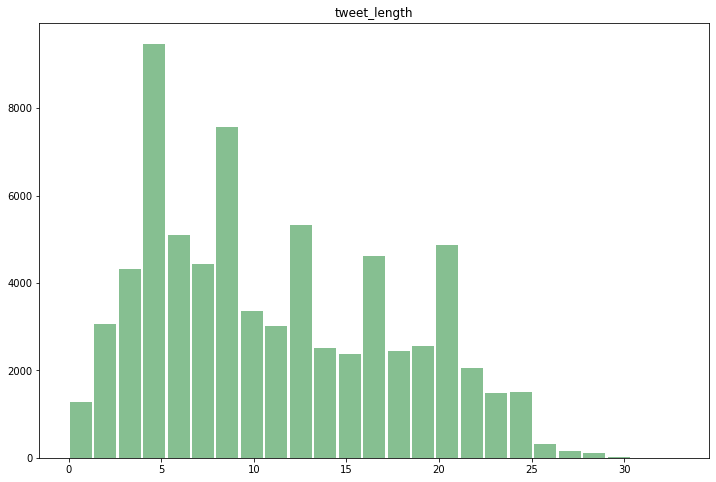

In [ ]:
final_df.hist(column='tweet_length',bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

We had a concern that some twitter accounts are not reliable for emotion analysis since it may not created by individuals. 

Then from the EDA of the tweet counts of each user during 12-01 to 12-09. We can mark the users who create more than 20 tweets as active users while others as inactive. Those account generate a lot of tweets in 9 days may not managed by single person and will affect out analysis.

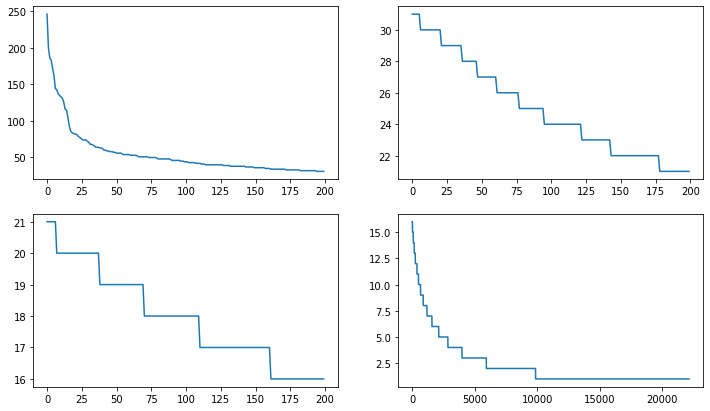

In [ ]:
# distribution of tweets number for each user.
# gridsize = (3, 2)
fig = plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2,2,1)
ax2= plt .subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
ax1.plot(final_df['screen_name'].value_counts().to_list()[:200])
ax2.plot(final_df['screen_name'].value_counts().to_list()[200:400])
ax3.plot(final_df['screen_name'].value_counts().to_list()[400:600])
ax4.plot(final_df['screen_name'].value_counts().to_list()[600:])
plt.show()

We explore the distribution of categorical features. Since we collect data in same amount for each city each day.The moon relate features is so flatten since it is only related to the time in a month. 
Sun realted featrures can be different among these cities due to the different latitude. But it stay the same for the same city in different day. 

After further tests we decided to drop these features since they are highly correlated and not important for weather identify. 

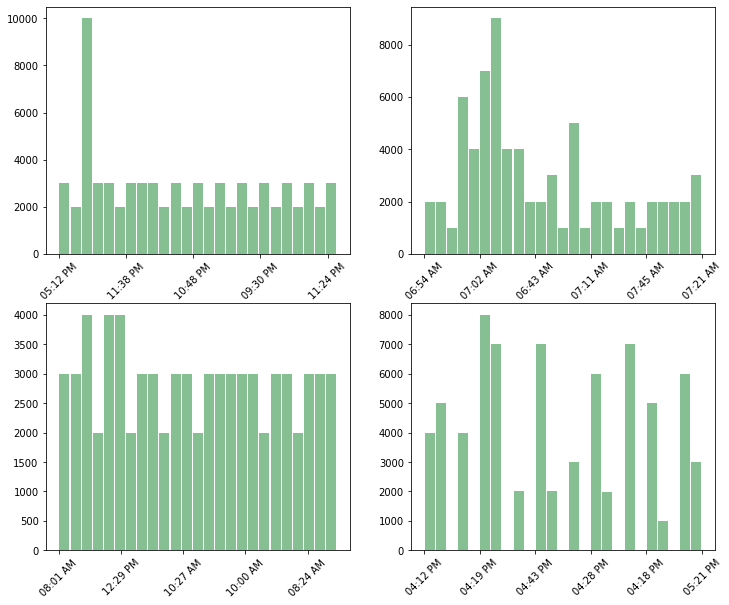

In [ ]:
# hist plot of categorical weather features. 
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,2,1)
ax2= plt .subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
ax1.hist(final_df['moonrise'],bins=25, color='#86bf91', zorder=2, rwidth=0.9)
ax2.hist(final_df['sunrise'],bins=25, color='#86bf91', zorder=2, rwidth=0.9)
ax3.hist(final_df['moonset'],bins=25, color='#86bf91', zorder=2, rwidth=0.9)
ax4.hist(final_df['sunset'],bins=25, color='#86bf91', zorder=2, rwidth=0.9)
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
ax4.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.tick_params(axis='x',labelrotation=45)
ax2.tick_params(axis='x',labelrotation=45)
ax3.tick_params(axis='x',labelrotation=45)
ax4.tick_params(axis='x',labelrotation=45)
plt.show()

Explore the variation of numerical weather data.
We can see data from different cities is highly different from each other, which produced enough diversity for us to generate different weather type description.

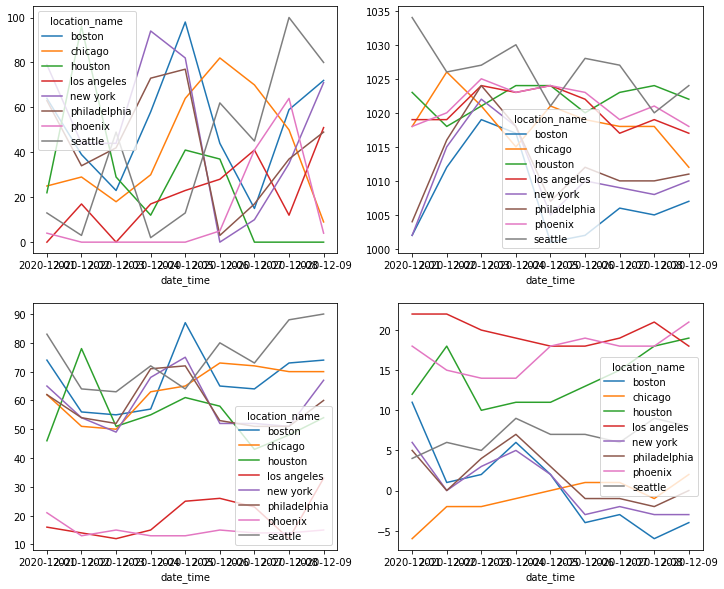

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,2,1)
ax2= plt .subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)
final_df.groupby(by=['date_time','location_name']).mean()['cloudcover'].unstack().plot(ax=ax1)
final_df.groupby(by=['date_time','location_name']).mean()['pressure'].unstack().plot(ax=ax2)
final_df.groupby(by=['date_time','location_name']).mean()['humidity'].unstack().plot(ax=ax3)
final_df.groupby(by=['date_time','location_name']).mean()['FeelsLikeC'].unstack().plot(ax=ax4)

Some features only have value for 2-3 cities, leave the rest undistinguish. But its still valuable together with other features.

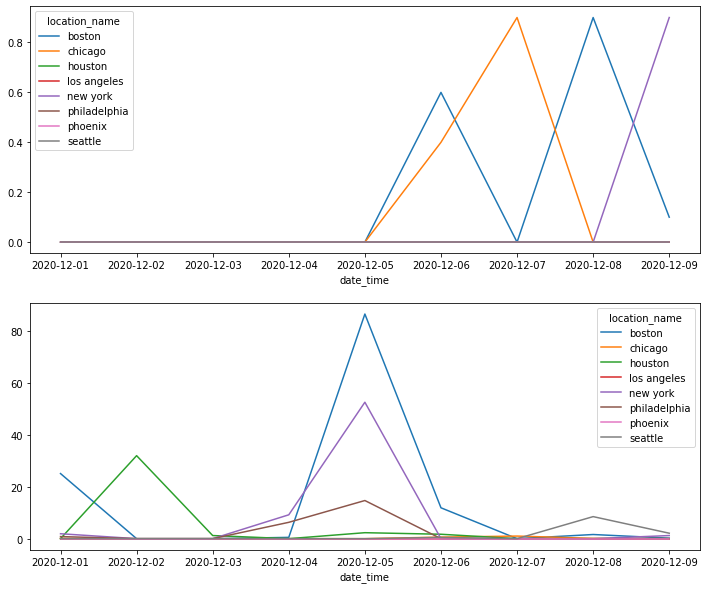

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,1,1)
ax2= plt .subplot(2,1,2)
final_df.groupby(by=['date_time','location_name']).mean()['totalSnow_cm'].unstack().plot(ax=ax1)
final_df.groupby(by=['date_time','location_name']).mean()['precipMM'].unstack().plot(ax=ax2)
# use unstack()

## 2.4 Convert Tweets Text to Emotion Score

In [ ]:
# defining the input and output files to this section
input_csv = "tweet_weather_formal_clean_Dec_10.csv"
output_csv = "tweet_weather_sentiment_formal_clean_Dec_11.csv"

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


First, using sentiment140 to classify as Positive (4), Netural (2), or Negative (0)

In [ ]:
# new checkpoint; loading most recent cleaned df
tweets_df = pd.read_csv(input_csv)

# extracting tweet text and saving to csv
tweets_df["tweets"].to_csv("sentiment140_input.txt", header = False, index = False)

In [ ]:
!curl --data-binary @"sentiment140_input.txt" "http://www.sentiment140.com/api/bulkClassify" --output "sentiment140_out.rar"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7981k  100 4174k  100 3807k   510k   465k  0:00:08  0:00:08 --:--:-- 1085k


In [ ]:
# getting output from sentiment140, rewriting it as a new column to tweets_df
with open('sentiment140_out.rar', 'r') as f:
    rows = f.read().split('\n')[:-1] # removing the empty last row entry

scores = []
for row in rows:
    score = int(row.split(',')[0].strip('\"')) # one of {0, 2, 4}
    scores.append(score)

# adding as series to the df
tweets_df["score_140"] = pd.Series(scores)

,labels,values
0,0,10083
1,2,48482
2,4,4124


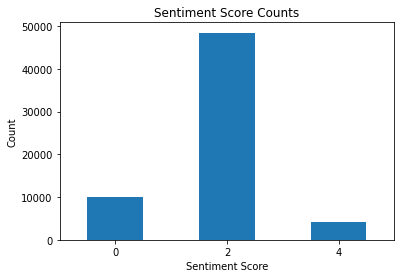

In [ ]:
# quick breakdown of sentiment stats
sentiment_count_series = tweets_df.groupby("score_140").size()
sentiment_count_df = pd.DataFrame({"labels": sentiment_count_series.index, "values": sentiment_count_series.values})
display(sentiment_count_df)

ax = sentiment_count_df.plot.bar(x="labels", y="values", rot=0)
ax.set_title("Sentiment Score Counts")
ax.set_xlabel("Sentiment Score")
ax.set_ylabel("Count")
ax.get_legend().remove()

The "Neutral" column is very biased... Attempting to see if sentiment can be better captured using a different sentiment analysis tool: NRCLex

NRCLex can be used to capture the frequencies of the following in a given tweet:
*   Anger
*   Anticipation*
*   Disgust
*   Fear
*   Joy
*   Negative
*   Positive
*   Sadness
*   Surprise
*   Trust

*skipping anticipation since its frequency dictionary sometimes uses "anticip" and "anticipation"

In [ ]:
with open("sentiment140_input.txt", 'r') as f:
    tweets_content_list = f.read().split('\n')

freqs_anger = []
freqs_disgust = []
freqs_fear = []
freqs_joy = []
freqs_negative = []
freqs_positive = []
freqs_sadness = []
freqs_surprise = []
freqs_trust = []

# get NRCLex scores, populate lists
for tweet in tweets_content_list:
    freq_dict = NRCLex(tweet).affect_frequencies
    freqs_anger.append(freq_dict["anger"])
    freqs_disgust.append(freq_dict["disgust"])
    freqs_fear.append(freq_dict["fear"])
    freqs_joy.append(freq_dict["joy"])
    freqs_negative.append(freq_dict["negative"])
    freqs_positive.append(freq_dict["positive"])
    freqs_sadness.append(freq_dict["sadness"])
    freqs_surprise.append(freq_dict["surprise"])
    freqs_trust.append(freq_dict["trust"])

# sanity check
print(len(freqs_anger))
print(len(freqs_disgust))
print(len(freqs_fear))
print(len(freqs_joy))
print(len(freqs_negative))
print(len(freqs_positive))
print(len(freqs_sadness))
print(len(freqs_surprise))
print(len(freqs_trust))

62690
62690
62690
62690
62690
62690
62690
62690
62690


In [ ]:
# add to tweets_df
tweets_df["score_anger"] = pd.Series(freqs_anger)
tweets_df["score_disgust"] = pd.Series(freqs_disgust)
tweets_df["score_fear"] = pd.Series(freqs_fear)
tweets_df["score_joy"] = pd.Series(freqs_joy)
tweets_df["score_negative"] = pd.Series(freqs_negative)
tweets_df["score_positive"] = pd.Series(freqs_positive)
tweets_df["score_sadness"] = pd.Series(freqs_sadness)
tweets_df["score_surprise"] = pd.Series(freqs_surprise)
tweets_df["score_trust"] = pd.Series(freqs_trust)

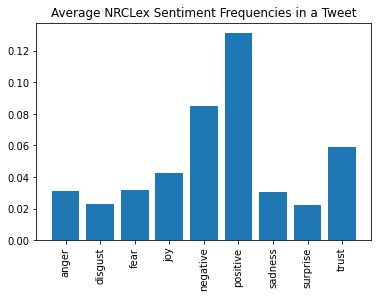

In [ ]:
plotting_dict = {
    "anger":    tweets_df["score_anger"].mean(),
    "disgust":  tweets_df["score_disgust"].mean(),
    "fear":     tweets_df["score_fear"].mean(),
    "joy":      tweets_df["score_joy"].mean(),
    "negative": tweets_df["score_negative"].mean(),
    "positive": tweets_df["score_positive"].mean(),
    "sadness":  tweets_df["score_sadness"].mean(),
    "surprise": tweets_df["score_surprise"].mean(),
    "trust":    tweets_df["score_trust"].mean()
}

plt.xticks(rotation='vertical')
plt.title(f"Average NRCLex Sentiment Frequencies in a Tweet")
ax = plt.bar(plotting_dict.keys(), plotting_dict.values())

This looks more promising. We'll go ahead and save the new `tweets_df` which now contains the sentiment scores

In [ ]:
# save to csv
tweets_df.to_csv(output_csv)

## 2.5 Weather Feature K-means Clustering

Since the weather has multiple columns, we would like to see if these naturally fall into clusters. Specifically, we aim to perform dimensionality reduction on the collected 23 data columns:

*   maxtempC
*   mintempC
*   totalSnow_cm
*   sunHour
*   uvIndex
*   moon_illumination
*   moonrise
*   moonset
*   sunrise
*   sunset
*   DewPointC
*   FeelsLikeC
*   HeatIndexC
*   WindChillC
*   WindGustKmph
*   cloudcover
*   humidity
*   precipMM
*   pressure
*   tempC
*   visibility
*   winddirDegree
*   windspeedKmph

Note: {moonrise, moonset, sunrise, sunset} are time series data and are thus ignored by pandas when performing a groupby.  We noticed {tempC}  is repeat value of maxtempC so we ignore it.

We opt to ignore these columns entirely, proceeding to perform dimensionality reduction on the remaining 18 columns and generate pratical labels by k-means clustering for further classifier training.

In [ ]:
# defining the input and output files to this section (subject to change)
input_csv = "tweet_weather_sentiment_formal_clean_Dec_11.csv"
output_kmeans_csv = '5labeled_traindataset_dec11.csv'

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


### 2.5.1 Weather features aggregation

In [ ]:
# projecting the weather features after grouping by location and date 
tweets_df = pd.read_csv(input_csv).iloc[:, 1:]
weather_features = [
    "maxtempC",
    "mintempC",
    "totalSnow_cm",
    "sunHour",
    "uvIndex", 
    "moon_illumination",
    "DewPointC",
    "FeelsLikeC",
    "HeatIndexC",
    "WindChillC",
    "WindGustKmph",
    "cloudcover",
    "humidity",
    "pressure",
    "precipMM",
    "visibility",
    "winddirDegree",
    "windspeedKmph"
]

grouped_weathers = tweets_df.groupby(by = ["location_name", "date_time"])
weather_features_df = grouped_weathers.mean()[weather_features]
display(weather_features_df)

maxtempC  mintempC  ...  winddirDegree  windspeedKmph
location_name date_time                       ...                              
boston        2020-12-01      16.0       7.0  ...          195.0           20.0
              2020-12-02       6.0       3.0  ...          225.0           19.0
              2020-12-03       9.0       2.0  ...          235.0           17.0
              2020-12-04      12.0       6.0  ...          227.0           19.0
              2020-12-05       7.0       2.0  ...          130.0           27.0
...                            ...       ...  ...            ...            ...
seattle       2020-12-05      15.0       3.0  ...          159.0            5.0
              2020-12-06      11.0       6.0  ...          178.0            8.0
              2020-12-07      11.0       1.0  ...          194.0            7.0
              2020-12-08      10.0       9.0  ...          262.0            7.0
              2020-12-09      10.0       6.0  ...          167.0            6.0

[72 rows x 18 columns]

In [ ]:
weather_features_df.describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,12.486111,6.458333,0.052778,7.020833,2.972222,60.111111,-2.166667,7.458333,9.444444,7.472222,17.041667,36.305556,51.666667,1017.513889,3.648611,9.458333,218.847222,12.430556
std,7.774993,6.366589,0.197143,2.160656,1.528805,18.895976,5.708901,8.428552,6.901498,8.453639,8.981103,29.356785,22.551350,7.451237,12.749106,1.197856,79.530959,6.651964
min,1.000000,-5.000000,0.000000,3.300000,1.000000,31.000000,-13.000000,-6.000000,-1.000000,-6.000000,4.000000,0.000000,12.000000,1001.000000,0.000000,4.000000,17.000000,3.000000
25%,5.000000,1.000000,0.000000,5.200000,2.000000,46.000000,-7.000000,0.000000,3.000000,0.000000,8.000000,11.500000,40.500000,1012.000000,0.000000,9.750000,168.500000,6.000000
50%,10.000000,4.000000,0.000000,8.700000,2.000000,60.000000,-3.000000,6.000000,7.500000,6.000000,16.000000,34.500000,55.000000,1019.000000,0.000000,10.000000,227.500000,11.500000
75%,20.250000,13.000000,0.000000,8.700000,4.000000,75.000000,2.000000,15.750000,16.500000,15.750000,25.000000,59.750000,68.500000,1023.000000,0.650000,10.000000,284.500000,18.000000
max,27.000000,19.000000,0.900000,8.700000,6.000000,89.000000,14.000000,22.000000,22.000000,23.000000,35.000000,100.000000,90.000000,1034.000000,86.600000,10.000000,342.000000,27.000000


### 2.5.2 Determine the best number of K-means cluster.

The weather data should not be normal variation, so we choose MinMaxScaler instead of StandardScaler.

 Then, for each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [ ]:

mms = MinMaxScaler()
mms.fit(weather_features_df)
data_transformed = mms.transform(weather_features_df)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

From the plot it seems that cluster number from **4-6** are the best. 

Since it is not so clear we have to perform silhouette method to further check it.

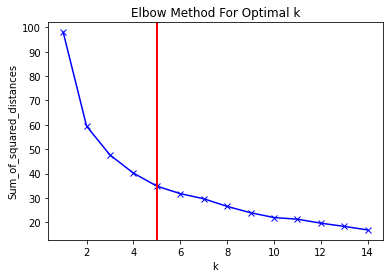

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(x = 5, linewidth = 2, color = 'r')
plt.show()

In [ ]:
sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
K = range(2,11)
for k in K:
  kmeans = KMeans(n_clusters = k).fit(data_transformed)
  labels = kmeans.labels_
  sil.append(silhouette_score(data_transformed, labels, metric = 'euclidean'))

From the plot, in the candidate interval of 4-6 given by Elbow Method, **5 seems to be the best number because of the highest silhouette score**. 

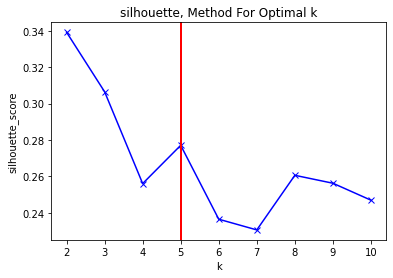

In [ ]:
plt.plot(K, sil,'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette, Method For Optimal k')
plt.axvline(x = 5, linewidth = 2, color = 'r')
plt.show()

Combine the result of silhouette method and Elbow method, 5 seem to be the best selection of cluster number.

In [ ]:
kmeans = KMeans(n_clusters = 5).fit(data_transformed)
labels = kmeans.labels_
weather_features_df['label']=labels

### 2.5.3 Found meaning for each cluster by observation.

Then we have to give the clusters practical meanings by observation. When label = 0, all the points have snow record so we mark it as:

**0: snowy day**

In [ ]:
weather_features_df[weather_features_df['label']==0]

maxtempC  mintempC  ...  windspeedKmph  label
location_name date_time                       ...                      
boston        2020-12-01      16.0       7.0  ...           20.0      0
              2020-12-05       7.0       2.0  ...           27.0      0
houston       2020-12-02      22.0      17.0  ...           16.0      0
new york      2020-12-01      12.0       4.0  ...           23.0      0
              2020-12-04       9.0       1.0  ...           15.0      0
              2020-12-05       7.0       4.0  ...           24.0      0
philadelphia  2020-12-01       9.0       4.0  ...           19.0      0
              2020-12-05       8.0       4.0  ...           22.0      0

[8 rows x 19 columns]

When label = 1, the points in this cluster all have high uvindex and warm temperature with no rain. So we mark it as:

**1: warm sunny day / desert like weather**

In [ ]:
weather_features_df[weather_features_df['label']==1].describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph,label
count,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.0,21.000000,21.000000,21.0
mean,22.714286,14.666667,0.0,8.000000,4.952381,57.000000,-5.571429,18.285714,18.476190,18.333333,10.523810,14.619048,21.619048,1021.142857,0.0,10.0,182.238095,7.428571,1.0
std,2.194148,2.175623,0.0,1.425132,0.740013,19.583156,6.273527,2.305273,2.015417,2.394438,6.705364,19.574157,12.555780,2.613154,0.0,0.0,77.300650,4.190124,0.0
min,19.000000,11.000000,0.0,3.800000,4.000000,31.000000,-13.000000,14.000000,15.000000,14.000000,5.000000,0.000000,12.000000,1017.000000,0.0,10.0,49.000000,4.000000,1.0
25%,22.000000,13.000000,0.0,8.700000,4.000000,38.000000,-10.000000,18.000000,18.000000,18.000000,6.000000,0.000000,14.000000,1019.000000,0.0,10.0,138.000000,5.000000,1.0
50%,23.000000,15.000000,0.0,8.700000,5.000000,53.000000,-8.000000,18.000000,19.000000,18.000000,7.000000,4.000000,15.000000,1022.000000,0.0,10.0,173.000000,6.000000,1.0
75%,24.000000,16.000000,0.0,8.700000,5.000000,75.000000,-3.000000,19.000000,19.000000,19.000000,13.000000,23.000000,25.000000,1023.000000,0.0,10.0,232.000000,9.000000,1.0
max,27.000000,19.000000,0.0,8.700000,6.000000,89.000000,9.000000,22.000000,22.000000,23.000000,28.000000,64.000000,54.000000,1025.000000,0.0,10.0,342.000000,20.000000,1.0


When we look at points in label = 2, all of them have more then 60% cloudover with no snow, and most instances don't have large precip, so we mark these as:

**2: cloudy/rainy day**

In [ ]:
weather_features_df[weather_features_df['label']==2].describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph,label
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0
mean,9.615385,5.384615,0.030769,3.615385,2.076923,62.230769,3.923077,6.000000,8.076923,6.000000,20.692308,79.615385,75.615385,1014.230769,18.384615,7.923077,202.230769,14.538462,2.0
std,4.908130,4.194013,0.110940,0.496397,0.759555,17.374089,4.554513,4.898979,4.290717,4.898979,10.176645,14.038865,8.732492,9.111841,25.730554,1.934836,77.151533,7.411875,0.0
min,3.000000,1.000000,0.000000,3.300000,1.000000,31.000000,-3.000000,0.000000,2.000000,0.000000,7.000000,62.000000,62.000000,1001.000000,0.000000,4.000000,62.000000,5.000000,2.0
25%,7.000000,2.000000,0.000000,3.400000,2.000000,53.000000,2.000000,2.000000,6.000000,2.000000,13.000000,64.000000,71.000000,1005.000000,0.800000,7.000000,167.000000,8.000000,2.0
50%,9.000000,4.000000,0.000000,3.500000,2.000000,60.000000,3.000000,5.000000,8.000000,5.000000,21.000000,80.000000,74.000000,1018.000000,8.500000,8.000000,195.000000,15.000000,2.0
75%,10.000000,6.000000,0.000000,3.600000,2.000000,67.000000,7.000000,8.000000,8.000000,8.000000,30.000000,94.000000,80.000000,1020.000000,25.100000,9.000000,239.000000,20.000000,2.0
max,22.000000,17.000000,0.400000,5.200000,4.000000,89.000000,14.000000,18.000000,19.000000,18.000000,35.000000,100.000000,90.000000,1028.000000,86.600000,10.000000,333.000000,27.000000,2.0


When label = 3, sunHour is longest but temprature is lower then label 1, and humidity is over 50% so we mark these as:

**3: cold-wet-sunny day**

In [ ]:
weather_features_df[weather_features_df['label']==3].describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph,label
count,11.000000,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,13.363636,5.909091,0.0,8.390909,3.272727,69.363636,2.363636,8.545455,9.363636,8.545455,11.454545,24.181818,62.727273,1025.181818,0.472727,9.818182,189.727273,8.272727,3.0
std,2.802596,3.618136,0.0,0.689136,0.646670,14.122838,1.689540,3.077780,3.074824,3.077780,5.871348,16.922282,10.527022,4.214693,0.846275,0.404520,103.747859,5.139862,0.0
min,9.000000,1.000000,0.0,6.900000,2.000000,46.000000,-1.000000,4.000000,5.000000,4.000000,4.000000,2.000000,46.000000,1020.000000,0.000000,9.000000,17.000000,3.000000,3.0
25%,11.500000,3.000000,0.0,8.700000,3.000000,60.000000,1.500000,6.000000,7.000000,6.000000,7.500000,12.500000,56.500000,1022.000000,0.000000,10.000000,131.000000,4.500000,3.0
50%,14.000000,6.000000,0.0,8.700000,3.000000,67.000000,2.000000,9.000000,9.000000,9.000000,10.000000,22.000000,63.000000,1024.000000,0.000000,10.000000,192.000000,7.000000,3.0
75%,15.500000,9.000000,0.0,8.700000,4.000000,78.500000,3.500000,11.000000,12.000000,11.000000,14.000000,39.000000,68.000000,1027.000000,0.600000,10.000000,260.500000,11.500000,3.0
max,17.000000,11.000000,0.0,8.700000,4.000000,89.000000,5.000000,13.000000,13.000000,13.000000,25.000000,49.000000,83.000000,1034.000000,2.300000,10.000000,341.000000,20.000000,3.0


Entries with label = 4 has the highest windGustKmph, the lowest temprature, the lowest uvindex, so mark it as:

**4: freezing windy**

In [ ]:
weather_features_df[weather_features_df['label']==4].describe()

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph,label
count,22.000000,22.0000,22.0,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.0
mean,6.181818,1.5000,0.0,7.836364,1.863636,61.818182,-4.318182,-0.136364,3.681818,-0.136364,23.045455,31.363636,56.454545,1014.227273,0.118182,9.954545,271.090909,17.454545,4.0
std,2.822298,1.8452,0.0,1.287132,0.560226,19.956229,2.834924,2.996751,2.398141,2.996751,5.250644,19.142437,6.493420,6.039015,0.412468,0.213201,33.679030,3.776207,0.0
min,1.000000,-2.0000,0.0,5.200000,1.000000,31.000000,-8.000000,-6.000000,0.000000,-6.000000,13.000000,0.000000,49.000000,1002.000000,0.000000,9.000000,224.000000,11.000000,4.0
25%,5.000000,0.2500,0.0,7.000000,2.000000,46.000000,-7.000000,-2.000000,2.000000,-2.000000,20.000000,17.250000,51.250000,1010.000000,0.000000,10.000000,241.500000,15.000000,4.0
50%,5.000000,1.0000,0.0,8.700000,2.000000,67.000000,-4.000000,-1.000000,3.000000,-1.000000,22.000000,32.000000,54.000000,1013.500000,0.000000,10.000000,273.000000,17.000000,4.0
75%,8.250000,3.0000,0.0,8.700000,2.000000,80.250000,-3.000000,1.750000,5.000000,1.750000,27.750000,43.500000,61.500000,1018.000000,0.000000,10.000000,301.750000,20.000000,4.0
max,12.000000,6.0000,0.0,8.700000,3.000000,89.000000,3.000000,6.000000,9.000000,6.000000,32.000000,79.000000,70.000000,1026.000000,1.900000,10.000000,321.000000,24.000000,4.0


### 2.5.4 Prepare for correlation matrix

Merge the weather data back to our sentiment dataframe. Drop the useless columns, keep the user_names since we may filter out some too active instance.

In [ ]:
labels = weather_features_df.reset_index()[['location_name','date_time','label']]
k_means_df=tweets_df.merge(labels,how='inner',on=["location_name", "date_time"])
k_means_df=k_means_df.drop(weather_features,axis=1)
k_means_df=k_means_df.drop(['Unnamed: 0.1','moonrise','moonset','sunset','sunrise','tempC'],axis=1)
k_means_df=k_means_df.drop(['tweets','location_name','date_time'],axis=1)

Save the dataset.

In [ ]:
k_means_df.to_csv(output_kmeans_csv)

In [ ]:
k_means_df

,screen_name,score_140,score_anger,score_disgust,score_fear,score_joy,score_negative,score_positive,score_sadness,score_surprise,score_trust,label
0,BrianDHalligan,0,0.125000,0.125000,0.000000,0.000000,0.250000,0.125000,0.250000,0.000000,0.000000,0
1,BrianDHalligan,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,helgaloo,2,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0
3,JoeJoecoolart,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,djmacandcheeze,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62684,Dejaaaa_______,2,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.200000,1
62685,LucasCaccavale,2,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,1
62686,DebraMoge,0,0.058824,0.058824,0.058824,0.117647,0.058824,0.176471,0.117647,0.117647,0.117647,1
62687,Dejaaaa_______,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


##2.6 PCA preprocess

We initially attempted PCA for dimensionality reduction of outputs for training our ML models, but later decided that categorical output would be more explainable in our model. So we perform KMeans clustering rather than outputting continuous data output streams.

But later a concern came out. We want to know that whether preprocessing with PCA can improve our k-means clustering, so we did a test using the PCA data.

In [8]:
input_csv = "tweet_weather_sentiment_formal_clean_Dec_11.csv"
output_pca_csv = "combined_pca_output_Dec_13.csv"
output_weather_means = "pca_reconstruction_data.txt"
output_weather_components = "pca_weather_components.csv"

In [9]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


### 2.6.1 PCA on Weather Features

Goal: Project out the 18 numeric weather features and perform dimensionality reduction。

ignore the tempC column since it repeat the value of maxtemp, ignore the datetime features since its not important for analysis.

In [10]:
# projecting the weather features after grouping by location and date 
tweets_df = pd.read_csv(input_csv).iloc[:, 1:]
weather_features = [
    "maxtempC",
    "mintempC",
    "totalSnow_cm",
    "sunHour",
    "uvIndex", 
    "moon_illumination",
    "DewPointC",
    "FeelsLikeC",
    "HeatIndexC",
    "WindChillC",
    "WindGustKmph",
    "cloudcover",
    "humidity",
    "pressure",
    "precipMM",
    "visibility",
    "winddirDegree",
    "windspeedKmph"
]

grouped_weathers = tweets_df.groupby(by = ["location_name", "date_time"])
weather_features_df = grouped_weathers.mean()[weather_features]
display(weather_features_df)

maxtempC  mintempC  ...  winddirDegree  windspeedKmph
location_name date_time                       ...                              
boston        2020-12-01      16.0       7.0  ...          195.0           20.0
              2020-12-02       6.0       3.0  ...          225.0           19.0
              2020-12-03       9.0       2.0  ...          235.0           17.0
              2020-12-04      12.0       6.0  ...          227.0           19.0
              2020-12-05       7.0       2.0  ...          130.0           27.0
...                            ...       ...  ...            ...            ...
seattle       2020-12-05      15.0       3.0  ...          159.0            5.0
              2020-12-06      11.0       6.0  ...          178.0            8.0
              2020-12-07      11.0       1.0  ...          194.0            7.0
              2020-12-08      10.0       9.0  ...          262.0            7.0
              2020-12-09      10.0       6.0  ...          167.0            6.0

[72 rows x 18 columns]

[0.49261137727809906, 0.6653570297702888, 0.771798420716803, 0.8453246725318786, 0.8962187014638574, 0.9257514483642739, 0.9523531248749256, 0.9685459545777331, 0.9807654017869465, 0.9902763699313765, 0.9936403561355012, 0.9962308425266786, 0.9982004706730294, 0.9990023436476374, 0.9994795936573903, 0.9997746676241435, 0.9999952044547546, 1.0]


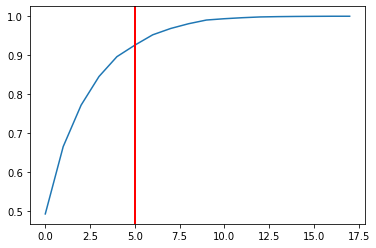

In [20]:
# performing PCA (thanks sklearn)
# Again using scaler to preprocess
mms = MinMaxScaler()
mms.fit(weather_features_df)
data_transformed = mms.transform(weather_features_df)
pca = PCA()
pca.fit(data_transformed)
cumulative_e_v_ratio = []
for i in range(len(pca.explained_variance_ratio_)):
    prev = 0 if i == 0 else cumulative_e_v_ratio[i - 1]
    cumulative_e_v_ratio.append(prev + pca.explained_variance_ratio_[i])
print(cumulative_e_v_ratio)
plt.plot(cumulative_e_v_ratio)
plt.axvline(x = 5, linewidth = 2, color = 'r')

In [21]:
# Indices 0 through 6 explain 92.57% of the variance
# transforming weather data into Principle Component Space
weather_pca_transform = pca.transform(data_transformed)[:, :6]

# each weather entries each explained by 6 components instead of 18
display(weather_pca_transform.shape)

(72, 6)

### 2.6.2 PCA on K-means cluster test

Then we will use the dimension reduced data to do K-means cluster.

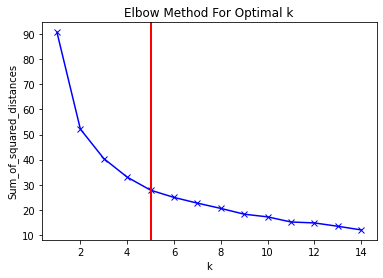

In [26]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(weather_pca_transform)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(x = 5, linewidth = 2, color = 'r')
plt.show()

Since it's hard to find the 'elbow' that makes the curve flatten in an particular point , we still need silhouette Method .

In [23]:
sil = []

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
K = range(2,11)
for k in K:
  kmeans = KMeans(n_clusters = k).fit(weather_pca_transform)
  labels = kmeans.labels_
  sil.append(silhouette_score(weather_pca_transform, labels, metric = 'euclidean'))

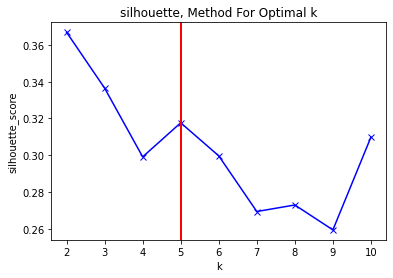

In [25]:
plt.plot(K, sil,'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('silhouette, Method For Optimal k')
plt.axvline(x = 5, linewidth = 2, color = 'r')
plt.show()

We can see that with preprocessing of PCA the optiaml number of k is still 5, and the silhouette_score doesn't show up a significant difference. Since it did not generate a more clear clustering and the meaning of each PCA component is hard to explain, so after this test we decided to drop PCA section and directly using K-means cluster result to make labels.

### [Archived] 2.6.3 PCA Conversion Sanity Check

Cartesian Space to Principle Component Space back to Cartesian Space on a small, dummy dataset

In [ ]:
# creating dummy dataframe

#temp_pca_df = pd.DataFrame.from_dict({"first": [2, 4, 6, 8, 10], "second": [1, 3, 5, 7, 9]})
#display(temp_pca_df)

# setup for pca and reconstruction

#mu = [np.mean(temp_pca_df).array]
#temp_pca = PCA()
#temp_pca.fit(temp_pca_df)

# transforming to pc space, only saving first PC

#temp_transformed = np.array([temp_pca.transform(temp_pca_df)[:, 0]])
#temp_score = np.array([temp_pca.components_[0]])
#print(f"First PC: {temp_transformed}")
#print(f"Vector: {temp_score}")

# returning to cartesian space

#temp_reconstructed = np.dot(temp_transformed.T, temp_score) + mu
#temp_reconstructed_df = pd.DataFrame(temp_reconstructed, columns = ["first", "second"])
#display(temp_reconstructed_df)

,first,second
0,2,1
1,4,3
2,6,5
3,8,7
4,10,9


First PC: [[ 5.65685425  2.82842712  0.         -2.82842712 -5.65685425]]
Vector: [[-0.70710678 -0.70710678]]


,first,second
0,2.0,1.0
1,4.0,3.0
2,6.0,5.0
3,8.0,7.0
4,10.0,9.0


### [Archived] 2.6.4 Saving Reconstruction Parameters

Using the process above to save important information in our real dataset for reconstruction later 

In [ ]:
# can't apply scaler
#pca = PCA()
#pca.fit(weather_features_df)
#weather_pca_transform = pca.transform(data_transformed)[:, :6]

In [ ]:
#pca_mu = [np.mean(weather_features_df).array]
#pca_scores = pca.components_[0:6]
#print(f"PC Dimensions to Original Dimensions: {pca_scores.shape}")

# Seeing how reconstruction performs on original data
#temp_reconstructed = np.dot(weather_pca_transform, pca_scores) + pca_mu
#temp_reconstructed_df = pd.DataFrame(temp_reconstructed, columns = [weather_features])
#display(temp_reconstructed_df)

# Saving the necessary data for reconstruction if needed later
#np.savetxt(output_weather_components, pca_scores, delimiter=",")
#with open(output_weather_means, 'w') as f:
#    for mu in pca_mu[0]:
#        f.write(f"{mu}\n")

PC Dimensions to Original Dimensions: (6, 18)


,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,pressure,precipMM,visibility,winddirDegree,windspeedKmph
0,12.820705,7.007424,-0.038103,5.380001,2.918238,88.950944,4.813833,8.064198,10.577975,8.095157,27.431981,65.204877,70.826924,1013.343028,31.087367,7.630594,195.404820,19.641269
1,6.637150,1.447051,0.062342,7.103722,1.901184,81.962089,-4.825905,0.533709,4.202906,0.545729,24.595952,39.325050,55.473128,1015.373987,1.610115,9.761584,225.138063,18.127862
2,8.005822,2.319198,0.038590,8.096245,2.373626,75.480969,-4.115782,1.753737,5.044619,1.767860,21.455728,22.975105,54.934583,1016.980365,0.721829,9.933430,235.023061,16.153365
3,9.678648,4.550278,0.087611,5.742529,2.184268,68.184469,-2.494027,4.768369,7.463203,4.782380,21.368033,58.211132,55.516306,1015.102109,4.057858,9.235076,227.181642,15.341228
4,10.243738,5.025964,0.022051,3.017136,2.535366,58.840058,7.542166,4.841789,8.768612,4.778501,44.128098,96.961376,90.459582,997.025760,79.739248,4.263730,129.604487,31.192822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,12.100766,5.384696,0.021854,8.466137,3.192807,59.549039,0.947675,7.028661,8.147940,7.021427,9.810955,13.031559,63.903289,1024.444140,0.074103,9.888424,159.015312,7.264676
68,10.214964,5.006169,0.098976,5.376577,2.213409,53.762601,5.698968,6.768536,7.614337,6.759897,9.357903,62.086943,79.488695,1023.075174,1.095092,9.061054,177.967577,6.270257
69,9.684745,4.244081,0.102829,6.448850,2.360169,46.718593,2.952643,5.457030,6.731387,5.440429,10.142962,44.667429,73.247530,1021.707532,-0.229200,9.350064,193.920671,7.227403
70,11.208151,7.097894,0.141740,2.953439,1.988957,38.016191,10.381804,9.073981,9.727913,9.084170,10.202730,99.935010,87.604155,1018.383487,8.120729,7.918091,261.943746,6.755548


### [Archived] 2.6.5 Updating Weather Columns with Principle Components

In [ ]:
keys = weather_features_df.reset_index()[["location_name", "date_time"]]
values = pd.DataFrame(weather_pca_transform, columns = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"])
weather_pca_outputs = keys.merge(values, left_index = True, right_index = True)
pca_output_combined_df = tweets_df.merge(weather_pca_outputs, left_on = ["location_name", "date_time"], right_on = ["location_name", "date_time"])
pca_output_combined_df.head(5)

,Unnamed: 0,Unnamed: 0.1,tweets,location_name,screen_name,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,score_140,score_anger,score_disgust,score_fear,score_joy,score_negative,score_positive,score_sadness,score_surprise,score_trust,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,0,0,jkspradlin DeanFB2 AMMcCarthy kyledcheney Your...,boston,BrianDHalligan,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,0,0.125,0.125,0.0,0.000000,0.25,0.125000,0.25,0.0,0.000000,23.091807,37.24677,27.287177,23.39059,13.298582,10.103844
1,1,1,jkspradlin DeanFB2 AMMcCarthy kyledcheney Meh ...,boston,BrianDHalligan,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,2,0.000,0.000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,23.091807,37.24677,27.287177,23.39059,13.298582,10.103844
2,2,2,VoLinxx Hello friend,boston,helgaloo,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,2,0.000,0.000,0.0,0.333333,0.00,0.333333,0.00,0.0,0.333333,23.091807,37.24677,27.287177,23.39059,13.298582,10.103844
3,3,3,Just waiting,boston,JoeJoecoolart,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,2,0.000,0.000,0.0,0.000000,0.00,0.000000,0.00,0.0,0.000000,23.091807,37.24677,27.287177,23.39059,13.298582,10.103844
4,4,4,gamecockjoe Boom Youre a life coach And if you...,boston,djmacandcheeze,2020-12-01,16,7,0.0,3.6,3,89,05:12 PM,08:01 AM,06:54 AM,04:12 PM,8,11,13,11,32,64,74,25.1,1002,16,9,195,20,4,0.000,0.000,0.0,0.000000,0.00,0.000000,0.00,0.0,1.000000,23.091807,37.24677,27.287177,23.39059,13.298582,10.103844


In [ ]:
# save to csv
pca_output_combined_df.to_csv(output_pca_csv)

In [ ]:
input_cleaning_csv = "combined_pca_output_Dec_13.csv"
output_cleaning_csv = "cleaned_ML_inputs_Dec_13.csv"

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

In [ ]:
tweets_df = pd.read_csv(input_csv).iloc[:, 1:]

weather_components = ["pc_1", "pc_2", "pc_3", "pc_4", "pc_5", "pc_6"]
score_components = ["score_140", "score_anger", "score_disgust", "score_fear", "score_joy", "score_negative", "score_positive", "score_sadness", "score_surprise", "score_trust"]
all_components = weather_components + score_components

cleaned_df = tweets_df[all_components]
display(cleaned_df)

cleaned_df.to_csv(output_cleaning_csv)

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,score_140,score_anger,score_disgust,score_fear,score_joy,score_negative,score_positive,score_sadness,score_surprise,score_trust
0,23.091807,37.24677,27.287177,23.390590,13.298582,10.103844,0,0.125000,0.125000,0.000000,0.000000,0.250000,0.125000,0.250000,0.000000,0.000000
1,23.091807,37.24677,27.287177,23.390590,13.298582,10.103844,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,23.091807,37.24677,27.287177,23.390590,13.298582,10.103844,2,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333
3,23.091807,37.24677,27.287177,23.390590,13.298582,10.103844,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,23.091807,37.24677,27.287177,23.390590,13.298582,10.103844,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62684,132.335121,-44.91510,-32.988664,-6.487008,-3.061611,12.974836,2,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.200000
62685,132.335121,-44.91510,-32.988664,-6.487008,-3.061611,12.974836,2,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000
62686,132.335121,-44.91510,-32.988664,-6.487008,-3.061611,12.974836,0,0.058824,0.058824,0.058824,0.117647,0.058824,0.176471,0.117647,0.117647,0.117647
62687,132.335121,-44.91510,-32.988664,-6.487008,-3.061611,12.974836,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 3. Model Fitting


In this section, we did correlation matrix on our features and trained our selected features and labels by using three different algorithms:

*   Random Forest
*   SVM
*   Naive Bayes

In [ ]:
input_ml_csv = "5labeled_traindataset_dec11.csv"

In [ ]:
%cd /content/gdrive/Shareddrives/CIS545_project/Data/

/content/gdrive/Shareddrives/CIS545_project/Data


##3.1 Correlation matrix and feature selection 

In [ ]:
ML_df = pd.read_csv(input_ml_csv)
ML_df

,Unnamed: 0,screen_name,score_140,score_anger,score_disgust,score_fear,score_joy,score_negative,score_positive,score_sadness,score_surprise,score_trust,label
0,0,BrianDHalligan,0,0.125000,0.125000,0.000000,0.000000,0.250000,0.125000,0.250000,0.000000,0.000000,0
1,1,BrianDHalligan,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,helgaloo,2,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.333333,0
3,3,JoeJoecoolart,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,4,djmacandcheeze,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62684,62684,Dejaaaa_______,2,0.000000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000,0.000000,0.200000,1
62685,62685,LucasCaccavale,2,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,1
62686,62686,DebraMoge,0,0.058824,0.058824,0.058824,0.117647,0.058824,0.176471,0.117647,0.117647,0.117647,1
62687,62687,Dejaaaa_______,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1


In [ ]:
temp_df=ML_df.groupby(by='screen_name').count().reset_index()[['screen_name','Unnamed: 0']]
ML_count_df=temp_df.merge(ML_df,how='inner',on=['screen_name'])
ML_count_df=ML_count_df.drop(['Unnamed: 0_y','screen_name'],axis=1)
ML_count_df=ML_count_df.rename(columns={'Unnamed: 0_x':"tweets_count"})

In [ ]:
display(ML_count_df)

,tweets_count,score_140,score_anger,score_disgust,score_fear,score_joy,score_negative,score_positive,score_sadness,score_surprise,score_trust,label
0,1,2,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1
1,3,2,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1
2,3,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
3,3,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1
4,1,0,0.2,0.2,0.2,0.000000,0.2,0.000000,0.2,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
62684,5,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4
62685,5,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,4
62686,5,2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3
62687,5,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3


We build a new feature called `tweets_count` that represent the cumulative number of tweets generated by the user in 2020-12-01 ~ 2020-12-09. Refer to this feature we can partition our samples into two user sources, one is active and another is inactive. 

Back up to the data visiualization part, from there we found that the too active accounts in the twitter are highly possible to be not owned by individual and thus should not be count for people's emotion analysis.  

In [ ]:
ML_count_df['active'] = ML_count_df['tweets_count'].apply(lambda x: 1 if x > 20 else 0)

In [ ]:
ML_count_df.drop(['tweets_count'],axis=1,inplace=True)

In [ ]:
ML_count_df['active'].value_counts()

0    47294
1    15395
Name: active, dtype: int64

From the correlation matrix we found that most features are unrelated so they can not be merged or inplaced by another. And all the features don't have a linear correlation with our target variable---the weather cluster. So regression type models may not fit well with our dataset. Based on this we decide to try three classification models:

*   Naive Bayes
*   SVM
*   RandomForest  

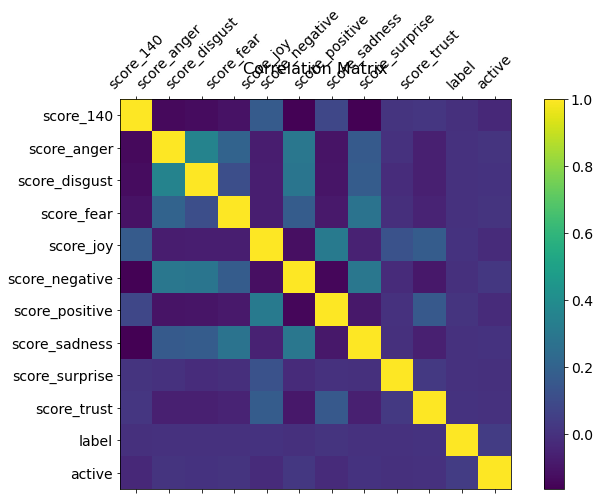

In [ ]:
f = plt.figure(figsize=(12, 7))
plt.matshow(ML_count_df.corr(), fignum=f.number)
plt.xticks(range(ML_count_df.shape[1]), ML_count_df.columns, fontsize=14, rotation=45)
plt.yticks(range(ML_count_df.shape[1]), ML_count_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## 3.2 Setup: Training and Testing Data


We will try 2 different dataset here to do model fitting:

*   (62,689) dataset generated from our original collected tweets
*   (47,294) dataset after dropping the too active accounts

The second one still has more then 47000 instance so we don't have to worry about data diversity, however may benefit from only keeping the tweets that are more likely to be created by human individuals.

We will mark the second dataset with a 2 suffix.

In [ ]:
X = ML_count_df.drop(columns = ["active","label"])
y = ML_count_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
##X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
X2 = ML_count_df[ML_count_df['active']==0].drop(columns = ["active","label"])
y2 =  ML_count_df[ML_count_df['active']==0]["label"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=10)

## 3.3 Train our model and tune parameters



Now, we can finally proceed to use three popular classification algorithms:

*   Naive Bayes
*   Random forest
*   SVC


### 3.3.1 Naive Bayes

In [ ]:
## Naive Bayes
var_list = [1, 1e-3, 1e-6, 1e-9, 1e-11, 1e-14]
parameters = {"var_smoothing" : var_list}
gnb = GaussianNB()
clf = GridSearchCV(gnb, parameters)
clf = clf.fit(X_train, y_train)
clf.best_params_

{'var_smoothing': 1}

Naive Bayes testing on Dataset 1 (62,689):

In [ ]:
gnb = GaussianNB(None, var_smoothing = 1)
y_pred = gnb.fit(X_train, y_train).predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("Naive Bayes's accuracy in train data:" + str(acc))
y_pred = gnb.fit(X_train, y_train).predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Naive Bayes's accuracy in test data:" + str(acc))

Naive Bayes's accuracy in train data:0.3323762238041116
Naive Bayes's accuracy in test data:0.3272451746690062


Naive Bayes testing on the filtered Dataset 2 (47,294):

In [ ]:
gnb = GaussianNB(None, var_smoothing = 1)
y_pred = gnb.fit(X2_train, y2_train).predict(X2_train)
acc = accuracy_score(y2_train, y_pred)
print("Naive Bayes's accuracy in train data:" + str(acc))
y_pred = gnb.fit(X2_train, y2_train).predict(X2_test)
acc = accuracy_score(y2_test, y_pred)
print("Naive Bayes's accuracy in test data:" + str(acc))

Naive Bayes's accuracy in train data:0.3513677811550152
Naive Bayes's accuracy in test data:0.3423194840892272


### 3.3.2 Support Vector Machine

In [ ]:
## SVM
Cs = [ 0.1, 1, 10]
gammas = [0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid)
grid_search.fit(X_train, y_train)
grid_search.best_params_

SVM testing on Dataset 1 (62,689):

In [ ]:
model = SVC(kernel='linear', C= 0.1, gamma = 0.01)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("SVC's accuracy in train data:" + str(acc))
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("SVC's accuracy in test data:" + str(acc))

SVC's accuracy in train data:0.3323762238041116
SVC's accuracy in test data:0.3272451746690062


SVM testing on the filtered Dataset 2 (47,294):

In [ ]:
model = SVC(kernel='linear', C= 0.1, gamma = 0.01)
model = model.fit(X2_train, y2_train)
y_pred = model.predict(X2_train)

acc = accuracy_score(y2_train, y_pred)
print("SVC's accuracy in train data:" + str(acc))
y_pred = model.predict(X2_test)
acc = accuracy_score(y2_test, y_pred)
print("SVC's accuracy in test data:" + str(acc))

SVC's accuracy in train data:0.3513677811550152
SVC's accuracy in test data:0.3423194840892272


### 3.3.3 Random Forest

Given the low initial testing accuracy, we seek to optimize the hyperparameters via iterative single-hyperparameter grid searching. We choose a more greedy approach in this section compared to the previous ones since there is a higher dimension of important hyperparameters to survey.

We seek to quickly/greedily optimize:
*   n_estimators
*   max_depth
*   min_samples_split
*   max_features

In [ ]:
## Random Forest
rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X_train,y_train)
print(rf0.oob_score_)
y_pred = rf0.predict(X_test)

0.31885705170385437


In [ ]:
acc = accuracy_score(y_test, y_pred)
print("RF's accuracy in test data:" + str(acc))

RF's accuracy in test data:0.3167171797734886


In [ ]:
param_test1 = {'n_estimators':range(10,101,10)}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt',oob_score=True), 
                       param_grid = param_test1, scoring='accuracy',cv=5)
gsearch1.fit(X,y)


In [ ]:
print( gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 60} 0.331015018324512


In [ ]:
param_test2 = {'max_depth':range(3,8,2)}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 60, 
                                  min_samples_leaf=20,min_samples_split=70,max_features=3 ,oob_score=True, random_state=10),
   param_grid = param_test2, scoring='accuracy', cv=5)
gsearch2.fit(X,y)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 3} 0.3313180969654436


In [ ]:
param_test3 = {'min_samples_split':range(60,121,10), 'min_samples_leaf':range(10,50,10)}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 60, max_depth=3,
                                  max_features= 3 ,oob_score=True, random_state=10),
   param_grid = param_test3, scoring='accuracy', cv=5)
gsearch3.fit(X,y)
print(gsearch3.best_params_, gsearch3.best_score_)

{'min_samples_leaf': 30, 'min_samples_split': 70} 0.331365951487696


In [ ]:
param_test4 = {'max_features':range(3,11,2)}
gsearch4 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 60, max_depth=3, min_samples_split=70,
                                  min_samples_leaf=30 ,oob_score=True, random_state=10),
   param_grid = param_test4, scoring='accuracy', cv=5)
gsearch4.fit(X,y)
print(gsearch4.best_params_, gsearch4.best_score_)

{'max_features': 3} 0.331365951487696


Although it shows that set max_features to 3 works better, but it is not explainable for only keeping 3 features since they are different aspect of emotion score, so we still decide to use all the features for training.

Now we can perform RFC testing on Dataset 1 (62,689):

In [ ]:
rfnew = RandomForestClassifier(n_estimators= 60, max_depth=3, max_features='auto',min_samples_split=70,
                                  min_samples_leaf=30 , random_state=10)


rfnew.fit(X_train,y_train)
#print(rfnew.oob_score_)
y_pred = rfnew.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("RF's accuracy in test data:" + str(acc))

RF's accuracy in test data:0.3272451746690062


In [ ]:
y_pred = rfnew.predict(X_train)
acc = accuracy_score(y_train, y_pred)
print("RF's accuracy in train data:" + str(acc))

RF's accuracy in train data:0.33239616358597035


And finally, RFC testing on the filtered Dataset 2 (47,294):

In [ ]:
rfnew.fit(X2_train,y2_train)
#print(rfnew.oob_score_)
y_pred = rfnew.predict(X2_test)
acc = accuracy_score(y2_test, y_pred)
print("RF's accuracy in test data:" + str(acc))
y_pred = rfnew.predict(X2_train)
acc = accuracy_score(y2_train, y_pred)
print("RF's accuracy in train data:" + str(acc))

RF's accuracy in test data:0.3423194840892272
RF's accuracy in train data:0.3514999339236157


Working with inactive subset seemed to have a better performance. So in future work, filter out the too active account may be a good strategy to get more reliable data.

## [Archived] Initial Model Testing

### [Archived] 3.1 Split data into train data and test data


In [ ]:

#dataset_file = '5labeled_traindataset_dec11.csv'
#dataset = pd.read_csv(dataset_file)
#X = dataset.drop(columns = ["Unnamed: 0","label", "screen_name"])
#y = dataset["label"]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### [Archived] 3.2 Train our model and tune parameters


In [ ]:
## Naive Bayes


#var_list = [1, 1e-3, 1e-6, 1e-9, 1e-11, 1e-14]
#parameters = {"var_smoothing" : var_list}
#gnb = GaussianNB()
#clf = GridSearchCV(gnb, parameters)
#clf = clf.fit(X_train, y_train)
#clf.best_params_


{'var_smoothing': 1}

In [ ]:
#gnb = GaussianNB(None, var_smoothing = 1)
#y_pred = gnb.fit(X_train, y_train).predict(X_train)
#acc = accuracy_score(y_train, y_pred)
#print("Naive Bayes's accuracy in train data:" + str(acc))
#y_pred = gnb.fit(X_train, y_train).predict(X_test)
#acc = accuracy_score(y_test, y_pred)
#print("Naive Bayes's accuracy in test data:" + str(acc))

Naive Bayes's accuracy in train data:0.3309604992921377
Naive Bayes's accuracy in test data:0.3329079598022013


In [ ]:
## SVM
#Cs = [0.001, 0.01, 0.1, 1, 10]
#gammas = [0.001, 0.01, 0.1, 1]
#param_grid = {'C': Cs, 'gamma' : gammas}
#grid_search = GridSearchCV(SVC(kernel='linear'), param_grid)
#grid_search.fit(X_train, y_train)
#grid_search.best_params_
#clf = clf.fit(X_train, y_train)
#clf.best_params_

In [ ]:
#model = SVC(kernel='linear', C= 0.1, gamma = 0.01)
#model = model.fit(X_train, y_train)
#y_pred = model.predict(X_train)
#acc = accuracy_score(y_train, y_pred)
#print("SVC's accuracy in train data:" + str(acc))
#y_pred = model.predict(X_test)
#acc = accuracy_score(y_test, y_pred)
#print("SVC's accuracy in test data:" + str(acc))

SVC's accuracy in train data:0.3309604992921377
SVC's accuracy in test data:0.3329079598022013


In [ ]:
## Random Forest

#depth = list(np.random.choice(500,5))
#nEstimator = list(np.random.choice(300,3))
#parameters = {'n_estimators': nEstimator, "max_depth": depth}
#model = RandomForestClassifier()
#clf = GridSearchCV(model, parameters)
#clf = clf.fit(X_train, y_train)
#clf.best_params_

{'max_depth': 17, 'n_estimators': 95}

In [ ]:

#model = RandomForestClassifier(n_estimators = 95, max_depth = 17)
#y_pred = model.fit(X_train, y_train).predict(X_train)
#acc = accuracy_score(y_train, y_pred.round())
#print("Random Forest's accuracy in train data:" + str(acc))
#y_pred = model.fit(X_train, y_train).predict(X_test)
#acc = accuracy_score(y_test, y_pred.round())
#print("Random Forest's accuracy in test data:" + str(acc))

Random Forest's accuracy in train data:0.38649279176885803
Random Forest's accuracy in test data:0.32501196363056306


# 4. Interpreting Results

## 4.1 Model Results Summary

The following is a table summarizing the model performances:

Model | Dataset 1 [Train, Test] | Dataset 2 [Train, Test]
--- | --- | ---
Naive Bayes            | `0.3323762238041116 / 0.3272451746690062` | `0.3513677811550152 / 0.3423194840892272`
Support Vector Machine | `0.3323762238041116 / 0.3272451746690062` | `0.3513677811550152 / 0.3423194840892272`
Random Forest          | `0.33239616358597035 / 0.3272451746690062` | `0.3514999339236157 / 0.3423194840892272`

These results seem a little suspicious. The three models we trained on our available datasets all had equal test dataset performance in terms of classification accuracy.

One might initially be tempted to say that, given 5 classes, we expect a baseline model to yield 20% accuracy and that these models are capturing some sort of correlation. However, this assumption ignores the inherent class imbalance in the data: it is not equally likely that it will be snowy vs. cloudy/rainy.

## 4.2 Baseline Model

To establish a proper baseline model for comparison, we consider the "dummy" edge-case classification that classifies **all of the data** into the "most likely" label in the training set (completely ignoring the inputs).

In [ ]:
# analyzing labels y_test and y2_test taken from 3.2
display(y_test.groupby(y_test).size())
display(y2_test.groupby(y2_test).size())

label
0    1043
1    4103
2    3370
3    1533
4    2489
Name: label, dtype: int64

label
0     795
1    3238
2    2573
3    1133
4    1720
Name: label, dtype: int64

In [ ]:
print(f"base accuracy (D1): {4103/y_test.size}")
print(f"base accuracy (D2): {3238/y2_test.size}")

base accuracy (D1): 0.3272451746690062
base accuracy (D2): 0.3423194840892272


There's our smoking gun explanation. All three of our models converged on a solution that said "the best we can do in predicting is completely ignoring the inputs and assuming everything comes from Category 1, the **warm sunny day / desert like weather** category"

## 4.3 Conclusion and Discussion

### 4.3.1 The **Big** Conclusion

As far as our analysis is concerned then, we conclude:

**<h2>There is no significant correlation between Tweet sentiment and Weather on a given day!</h2>**

### 4.3.2 Supplementary Discussion

Potential sources of error include our Tweet retrieval filtering, our K-Means clustering of weather data, way of representing sentiment scores, and model choices, among other qualitative behavioral considerations. We briefly discuss each of these below.

#### 4.3.2.1 Tweet Retrieval

During Tweet Retrieval, and the data cleaning process, we filtered out emojis and kept in tweets of shorter lengths. There may have been some inherent skewing of the data by using this approach, however the effects on our final conclusion are likely minimal relative to other challenges and potential sources of error.

#### 4.3.2.2 Weather Categories

Categorizing the roughly 20 continuous data metrics into five distinct categories involved a degree of educated inferencing and decision making, however it was still a user choice.

It is possible that clustering into greater or fewer categories could yield a different outcome, or even by clustering using a more generalization clustering approach rather than a method that equally weighs each data feature for calculating the distance metric to the nearest cluster.

To this end, another approach to consider is using heirarchical clustering to see how closely related specific subsets of point entities are to each other and use that a metric to quantify how related groupings are to each other.

#### 4.3.2.3 Sentiment Scores

Sentiment was initially calculated using sentiment140, until realizing that the majority of tweets were classified as "neutral" (48,482/62,689 tweets) under this classifier. Keeping this as an input feature but also using the NRC Lexicon for sentiment analysis was an explicit choice that gave rise to an additional nine input features to consider.

However, worth noting is that the sentiment scores using NRC Lexicon were reported in our dataset as a frequency score, meaning a tweet that only contains 10 positive words, 10 joy words, and 10 surprise words would each translate to values of 0.33, 0.33, 0.33 in each respective feature column. Perhaps upweighting these by tabulating the overall count of sentiment words in each category rather than the frequency breakdown would provide a better sense of the magnitude of sentiment a Tweet contains rather than simply the direction of sentiment it is leaning towards.

#### 4.3.2.4 Model Choices

We considered the possibility that more delicate correlations could exist in the data that could be extracted via a Convuluted Neural Net classifier, but the training data we would be able to pass in this scenario would be insufficiently small for the number of Tweets we consider (~70,000 overall) to really train up a complicated net that won't overfit the training data.

#### 4.3.2.5 Qualitative Analysis

In addition to all of these data analysis choices that could have an affect on the data, we also briefly ponder the implications of the results. The main interpretation is that the sentiment we measured has no correlation with the weather.

If we do expect some sort of relationship to exist, perhaps it is the case that only "bad" weather would create a minor negative impact on someone's day, and what is classified as "bad" weather is likely not uniform. This is verified by quickly realizing everyone has a different favorite season or time of year where they think the weather is best.